In [ ]:
import sys
from pathlib import Path
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import importlib

# 讓 Python 找得到 src 資料夾
# 假設 notebook 在專案根目錄 (跟 src 同層)
sys.path.append(str(Path.cwd()))

# 設定繪圖風格
sns.set_theme(style="whitegrid")
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'Microsoft JhengHei']
plt.rcParams['axes.unicode_minus'] = False

In [ ]:
# 取得目前 notebook 的路徑 (例如 D:\NCKU\paper4\script)
current_dir = Path.cwd()

# 取得上一層目錄 (專案根目錄，例如 D:\NCKU\paper4)
project_root = current_dir.parent

# 把根目錄加入 Python 的搜尋路徑
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))
    print(f"已加入專案路徑: {project_root}")

# reload
to_delete = [m for m in sys.modules if m.startswith('src')]

for m in to_delete:
    del sys.modules[m]

print(f"已清理模組: {to_delete}")

import src.utils.data_loader as data_loader
import src.engine.trainer as trainer
import src.engine.evaluator as evaluator

# 硬體設定
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on: {DEVICE}")

In [36]:
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


# 全域設定
DATA_PATH = Path("../dataset/USD_TWD.csv")
HORIZON = 3
LOOKBACK = 30
EPOCHS = 100
LR = 0.001
SEED = 42
CNNEXPERT_KERNELSIZE = 5
SERIESDECOMPOSITION_KERNELSIZE = 29

# 設定隨機性 (Reproducibility)
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)


In [37]:
if not DATA_PATH.exists():
    raise FileNotFoundError("找不到資料集！")

df = pd.read_csv(DATA_PATH)

# 載入資料
train_loader, test_loader, scalers, _, _, _, _ = data_loader.prepare_data(
    df, lookback=LOOKBACK, horizon=HORIZON
)

print(f"Data ready. Train batches: {len(train_loader)}, Test batches: {len(test_loader)}")

Data ready. Train batches: 167, Test batches: 42


In [38]:
ablation_experiments = [
    {
        "name": "Full Model (Baseline)",
        "params": {"use_revin": True}  # 空字典 = 全部使用預設值 (全開)
    },
    {
        "name": "w/o RevIN",
        "params": {"use_revin": False}  # <--- 你的測試重點
    },
    {
        "name": "w/o CNN",
        "params": {"use_revin": True, "use_cnn": False}  # 關閉 CNN
    },
    {
        "name": "w/o Decomposition",
        "params": {"use_decomp": False}  # 關閉序列分解
    },
    # 如果你有做 Gate 機制也可以測
    # {
    #     "name": "w/o Gating",
    #     "params": {"use_gate": False}
    # }
]

In [39]:
results = []

print(f"開始執行 {len(ablation_experiments)} 組消融實驗...\n")

for i, exp in enumerate(ablation_experiments):
    exp_name = exp["name"]
    exp_params = exp["params"]

    print(f"[{i + 1}/{len(ablation_experiments)}] Running: {exp_name}")
    print(f"   Params: {exp_params}")

    # 1. 重置種子
    set_seed(42)

    # 2. 訓練模型
    model = trainer.train_v11(
        train_loader=train_loader,
        test_loader=test_loader,
        device=DEVICE,
        horizon=HORIZON,
        num_epochs=EPOCHS,
        lr=LR,
        cnnExpert_KernelSize=CNNEXPERT_KERNELSIZE,
        seriesDecomposition_KernelSize=SERIESDECOMPOSITION_KERNELSIZE,
        model_hyperparams=exp_params
    )

    # 3. 評估模型 (修正點：移除 scaler 參數)
    metrics = evaluator.evaluate_model(
        model=model,
        test_loader=test_loader,
        device=DEVICE,  # <--- 修正：只傳入 device 和 horizon
        horizon=HORIZON
    )

    # 4. 儲存結果
    record = {"Experiment": exp_name}
    record.update(metrics)
    results.append(record)

    # 修正點：改印 RMSE_Final
    rmse = metrics.get('RMSE_Final', 0.0)
    print(f"   Result: RMSE={rmse:.4f}\n")

print("所有實驗結束！")


開始執行 4 組消融實驗...

[1/4] Running: Full Model (Baseline)
   Params: {'use_revin': True}

[Training] Enhanced DLinear...
  Epoch 20 | Loss: 0.5231 | Trend W: -0.025 | Seas W: 0.095
  Epoch 40 | Loss: 0.4816 | Trend W: -0.033 | Seas W: 0.113
  Epoch 60 | Loss: 0.4457 | Trend W: -0.045 | Seas W: 0.137
  Epoch 80 | Loss: 0.4245 | Trend W: -0.052 | Seas W: 0.153
  Epoch 100 | Loss: 0.4239 | Trend W: -0.054 | Seas W: 0.155

 FINAL MODEL EVALUATION (Horizon=3): Ablation Study (RevIN Enabled)
Metric               | Linear Base     | Base + CNN      | Improvement    
-----------------------------------------------------------------------------------------------
RMSE                 | 2.3312          | 1.7819          | -0.5493
R2 Score             | 0.5714          | 0.7496          | +0.1782
Avg Accuracy         | 0.5587          | 0.7128          | +0.1541
High Vol Accuracy    | 0.7085          | 0.8695          | +0.1610
   Result: RMSE=1.7819

[2/4] Running: w/o RevIN
   Params: {'use_revin': 


=== Ablation Study Results ===


,Experiment,RMSE_Final,RMSE_Base,R2_Final,High_Vol_Acc
0,Full Model (Baseline),1.781860,2.331199,0.749588,0.869455
1,w/o RevIN,1.696735,2.377577,0.772942,0.822560
2,w/o CNN,1.841590,1.841590,0.732518,0.765526
3,w/o Decomposition,1.829914,2.178438,0.735899,0.864385


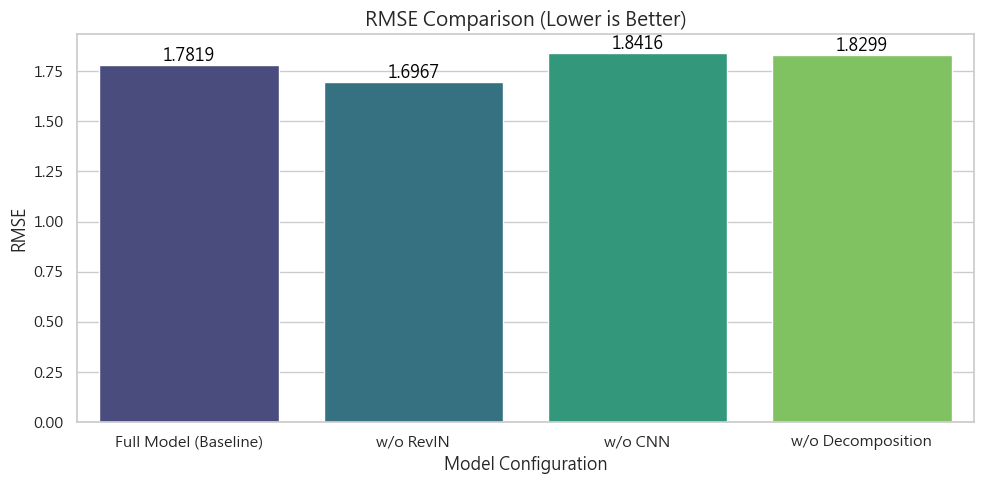

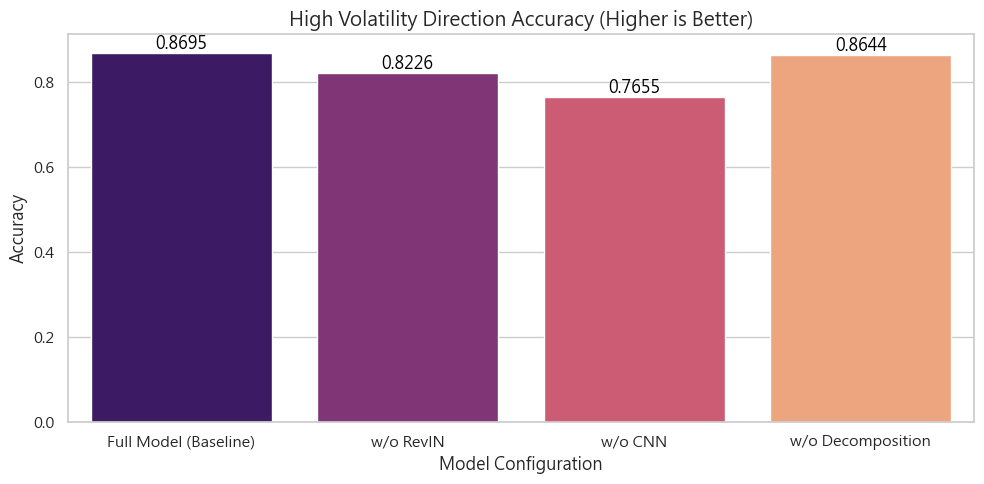

In [40]:
# 轉成 DataFrame
df_res = pd.DataFrame(results)

# 顯示表格
print("\n=== Ablation Study Results ===")
display(df_res)

# === 畫圖比較 1: RMSE (越低越好) ===
plt.figure(figsize=(10, 5))
# 修正點：y 改為 'RMSE_Final'
sns.barplot(data=df_res, x='Experiment', y='RMSE_Final', hue='Experiment', palette='viridis', legend=False)

plt.title(f"RMSE Comparison (Lower is Better)", fontsize=14)
plt.ylabel("RMSE")
plt.xlabel("Model Configuration")

for index, row in df_res.iterrows():
    plt.text(index, row['RMSE_Final'], f"{row['RMSE_Final']:.4f}", color='black', ha="center", va="bottom")

plt.tight_layout()
plt.show()

# === 畫圖比較 2: Direction Accuracy (越高越好) ===
# 這可以驗證你 "RevIN 是否犧牲方向準確率" 的假設
plt.figure(figsize=(10, 5))
sns.barplot(data=df_res, x='Experiment', y='High_Vol_Acc', hue='Experiment', palette='magma', legend=False)

plt.title(f"High Volatility Direction Accuracy (Higher is Better)", fontsize=14)
plt.ylabel("Accuracy")
plt.xlabel("Model Configuration")

for index, row in df_res.iterrows():
    plt.text(index, row['High_Vol_Acc'], f"{row['High_Vol_Acc']:.4f}", color='black', ha="center", va="bottom")

plt.tight_layout()
plt.show()
